Image classification is a fundamental task in computer vision that involves assigning an image to a particular category or label. In this homework assignment, you will build and train a Convolutional Neural Network (CNN) model to classify images of dogs and cats. You will also apply transfer learning techniques using the VGG pre-trained model to improve the performance of the classification task.

The assignment consists of several steps, including data preparation, building and training a CNN model, applying transfer learning with VGG, evaluating the performance of the models, and making improvements to the models.

This assignment will give you hands-on experience with CNNs, transfer learning, and image classification techniques. You will also learn how to interpret the learned features and discuss the advantages and limitations of using CNNs and transfer learning for image classification tasks.

Assignment
Data Preparation: Download a dataset of dog and cat images or collect images from the internet. Split the dataset into training and testing sets, and ensure the images are resized to a fixed size to be compatible with the CNN model.
Build a CNN Model: Build a Convolutional Neural Network (CNN) model using Keras or Tensorflow libraries. The model should contain multiple convolutional and pooling layers, followed by fully connected layers for classification.
Train the CNN Model: Train the CNN model using the training set of images. Use the categorical cross-entropy loss function and the Adam optimizer to minimize the loss. Then, evaluate the model's performance using the testing set of images.
Transfer Learning with VGG: Load the VGG pre-trained model, which was trained on a large dataset of images. Freeze the weights of the convolutional layers and add fully connected layers on top for classification. Next, fine-tune the fully connected layers on the dog and cat dataset using the training set of images.
Evaluate the Performance: Evaluate the performance of the transfer learning model using the testing set of images. Compare the performance of the transfer learning model with the CNN model trained from scratch.
Improvements: Try to improve the model's performance by adjusting the hyperparameters, adding regularization techniques, or using other pre-trained models for transfer learning.
Report and Interpretation: Write a report summarizing the results of the classification task and the interpretation of the learned features. Discuss the advantages and limitations of using CNNs and transfer learning for image classification tasks.


In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import plotly.express as px
import scipy as sp

from scipy import ndimage
from shutil import copyfile
from tensorflow.keras.layers import Conv2D,Add,MaxPooling2D, Dense, BatchNormalization,Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [8]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shaunthesheep/microsoft-catsvsdogs-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1


In [10]:
# Step 1: Define Paths

import os

# Define dataset paths
base_dir = "/root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1/PetImages"
cat_path = os.path.join(base_dir, "Cat")
dog_path = os.path.join(base_dir, "Dog")

# Check if directories exist
print("Cat directory exists:", os.path.exists(cat_path))
print("Dog directory exists:", os.path.exists(dog_path))


Cat directory exists: True
Dog directory exists: True


In [11]:
# Step 2: Count Images
n_cats = len([f for f in os.listdir(cat_path) if f.endswith(('.jpg', '.png'))])
n_dogs = len([f for f in os.listdir(dog_path) if f.endswith(('.jpg', '.png'))])

print(f"Number of cat images: {n_cats}")
print(f"Number of dog images: {n_dogs}")


Number of cat images: 12500
Number of dog images: 12500


In [12]:
# Step 3: Visualize Data Distribution
import plotly.express as px

class_names = ['Cat', 'Dog']
n_images = [n_cats, n_dogs]

# Plot class distribution
fig = px.pie(names=class_names, values=n_images, title="Distribution of Cat and Dog Images")
fig.show()


2. Data Processing

In [13]:
# 1. Define Image Preprocessing Pipelines

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image size and batch size
img_size = 150
batch_size = 32

# Create ImageDataGenerator for training (with augmentation)
train_datagen = ImageDataGenerator(
    rescale=1./255,    # Normalize pixel values to [0,1]
    rotation_range=20,  # Random rotation
    width_shift_range=0.2,  # Horizontal shift
    height_shift_range=0.2,  # Vertical shift
    shear_range=0.2,    # Shear transformations
    zoom_range=0.2,     # Random zoom
    horizontal_flip=True,  # Flip images horizontally
    validation_split=0.2  # Split 20% of data for validation
)

# Load training images
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',  # Binary classification (Cat vs. Dog)
    subset='training'
)

# Load validation images
val_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)


Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


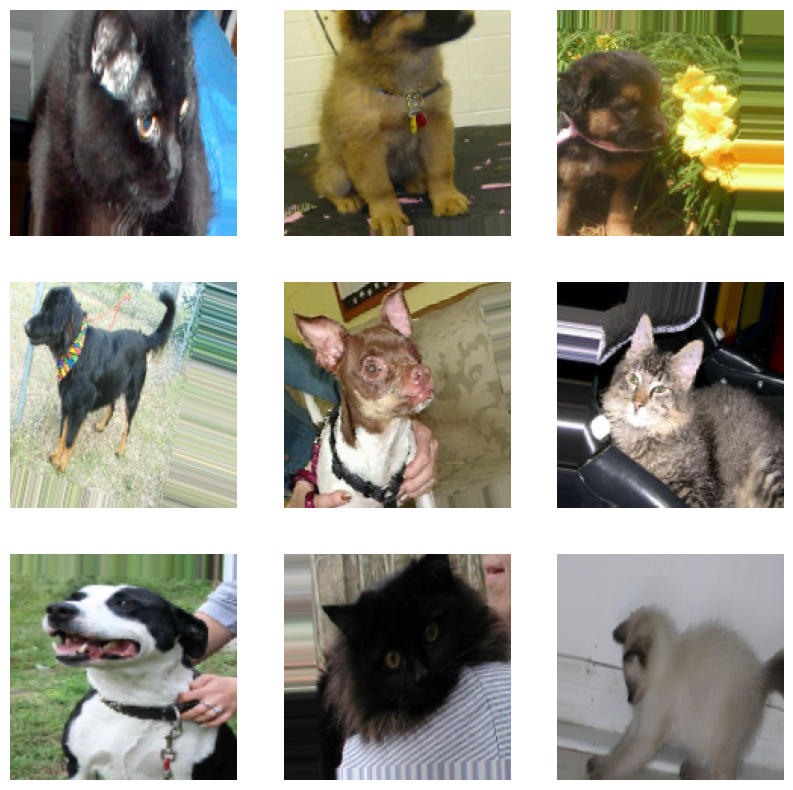

In [14]:
# 2. Visualize Sample Images
# Get a batch of training images
sample_images, sample_labels = next(train_generator)

# Plot images
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(sample_images[i])
    plt.axis("off")
plt.show()


3.  Build the CNN Model

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Step 1 :Define CNN model
model = Sequential([
    # First Convolutional Block
    Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2,2),

    # Second Convolutional Block
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    # Third Convolutional Block
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    # Flatten the features
    Flatten(),

    # Fully connected layers
    Dense(512, activation='relu'),
    Dropout(0.5),  # Prevent overfitting
    Dense(1, activation='sigmoid')  # Binary classification (Cat vs. Dog)
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      18,940,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
import os
from PIL import Image

def remove_corrupt_images(directory):
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        try:
            img = Image.open(filepath)
            img.verify()  # Verify that the file is an image
        except (IOError, SyntaxError):
            print(f"Removing corrupted image: {filepath}")
            os.remove(filepath)

# Remove corrupt images from both classes
remove_corrupt_images('/root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1/PetImages/Cat')
remove_corrupt_images('/root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1/PetImages/Dog')


Removing corrupted image: /root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1/PetImages/Cat/Thumbs.db
Removing corrupted image: /root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1/PetImages/Cat/666.jpg
Removing corrupted image: /root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1/PetImages/Dog/Thumbs.db
Removing corrupted image: /root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1/PetImages/Dog/11702.jpg


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning:

Truncated File Read



In [ ]:
# Step 2 : Train the model

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,  # You can increase the number of epochs
    verbose=1
)


Epoch 1/10
 11/625 ━━━━━━━━━━━━━━━━━━━━ 20:48 2s/step - accuracy: 0.7115 - loss: 0.5726

In [ ]:
#Step 3 : Plot Result

import matplotlib.pyplot as plt

# Extract loss and accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()
